# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import numpy as np
import hydra
import copy
from omegaconf import OmegaConf, open_dict
%load_ext autoreload
%autoreload 2

import breaching
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=clsattack'])
    cfg.case.server.name = 'class_malicious_parameters'
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

ANTLR runtime and generated code versions disagree: 4.7.2!=4.8
ANTLR runtime and generated code versions disagree: 4.7.2!=4.8
ANTLR runtime and generated code versions disagree: 4.7.2!=4.8
ANTLR runtime and generated code versions disagree: 4.7.2!=4.8
Investigating use case single_imagenet with server type class_malicious_parameters.


{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [20]:
with open_dict(cfg):
    cfg.case.data.partition = "mixup"
    cfg.case.user.user_idx = 1
    cfg.case.user.num_data_points = 4
    cfg.case.model = 'resnet18'
    cfg.case.server.model_state = 'trained'
    cfg.case.user.provide_labels = True
    cfg.case.user.provide_buffers = True
    cfg.case.user.provide_num_data_points = True

#     cfg.attack.regularization.total_variation.scale = 0.2
#     cfg.attack.regularization.total_variation.inner_exp = 2
#     cfg.attack.regularization.total_variation.outer_exp = 0.5
#     # cfg.attack.optim.signed = 'hard'
#     cfg.attack.optim.step_size_decay = 'cosine-decay'
#     cfg.attack.optim.warmup = 50
#     # cfg.attack.optim.step_size = 1e-2
#     cfg.attack.init = 'patterned-4'  # 'patterned-4'
#     cfg.attack.objective.task_regularization = .0
#     cfg.attack.regularization.features = .0
#     cfg.attack.regularization.total_variation.double_opponents = True
#     cfg.attack.regularization.deep_inversion = dict(scale=.0)

    cfg.attack.optim.max_iterations = 0

### Instantiate all parties

In [21]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture resnet18 loaded with 11,689,512 parameters and 9,620 buffers.
Overall this is a data ratio of      19:1 for target shape [4, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 4

    Threat model:
    User provides labels: True
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 1
    
        
Server (of type ClassParameterServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: trained
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.2. p=2 q=0.5. Color TV: double oppponents (

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [5]:
# modify the model to catch the class we want
which_to_recover = 0
how_many = 1
how_many_rec = 1

server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)
t_labels = shared_data['metadata']['labels'].cpu().detach().numpy()
cls_to_obtain = t_labels[which_to_recover:(which_to_recover + how_many)]
extra_info = {'cls_to_obtain': cls_to_obtain}

# apply finishing attack
# for now: apply simple transformation to make pseudo target
target_img = true_user_data['data'][which_to_recover]
target_img = server.random_transoformation(target_img)
target_cls = int(t_labels[which_to_recover])

server.reset_model()
# server.fishing_attack_retrain(target_img, target_cls=target_cls, dataset_len=16000)
# # extra_info['b_mv'] = 0
# extra_info['b_mv'] = -(float(server.model(target_img.unsqueeze(0))[which_to_recover][target_cls])) * 2
# extra_info['b_mv_non'] = 0
# extra_info['multiplier'] = 100
# server.reconfigure_model('fishing_attack', extra_info=extra_info)

100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 71.39batch/s, loss=0.318]


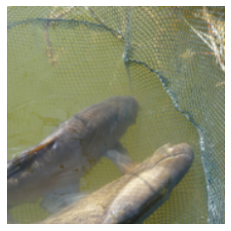

In [6]:
user.plot({'data': target_img.unsqueeze(0), 'labels': None})

In [29]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# [(g.mean(), g.std()) for g in shared_data['gradients'][0]]

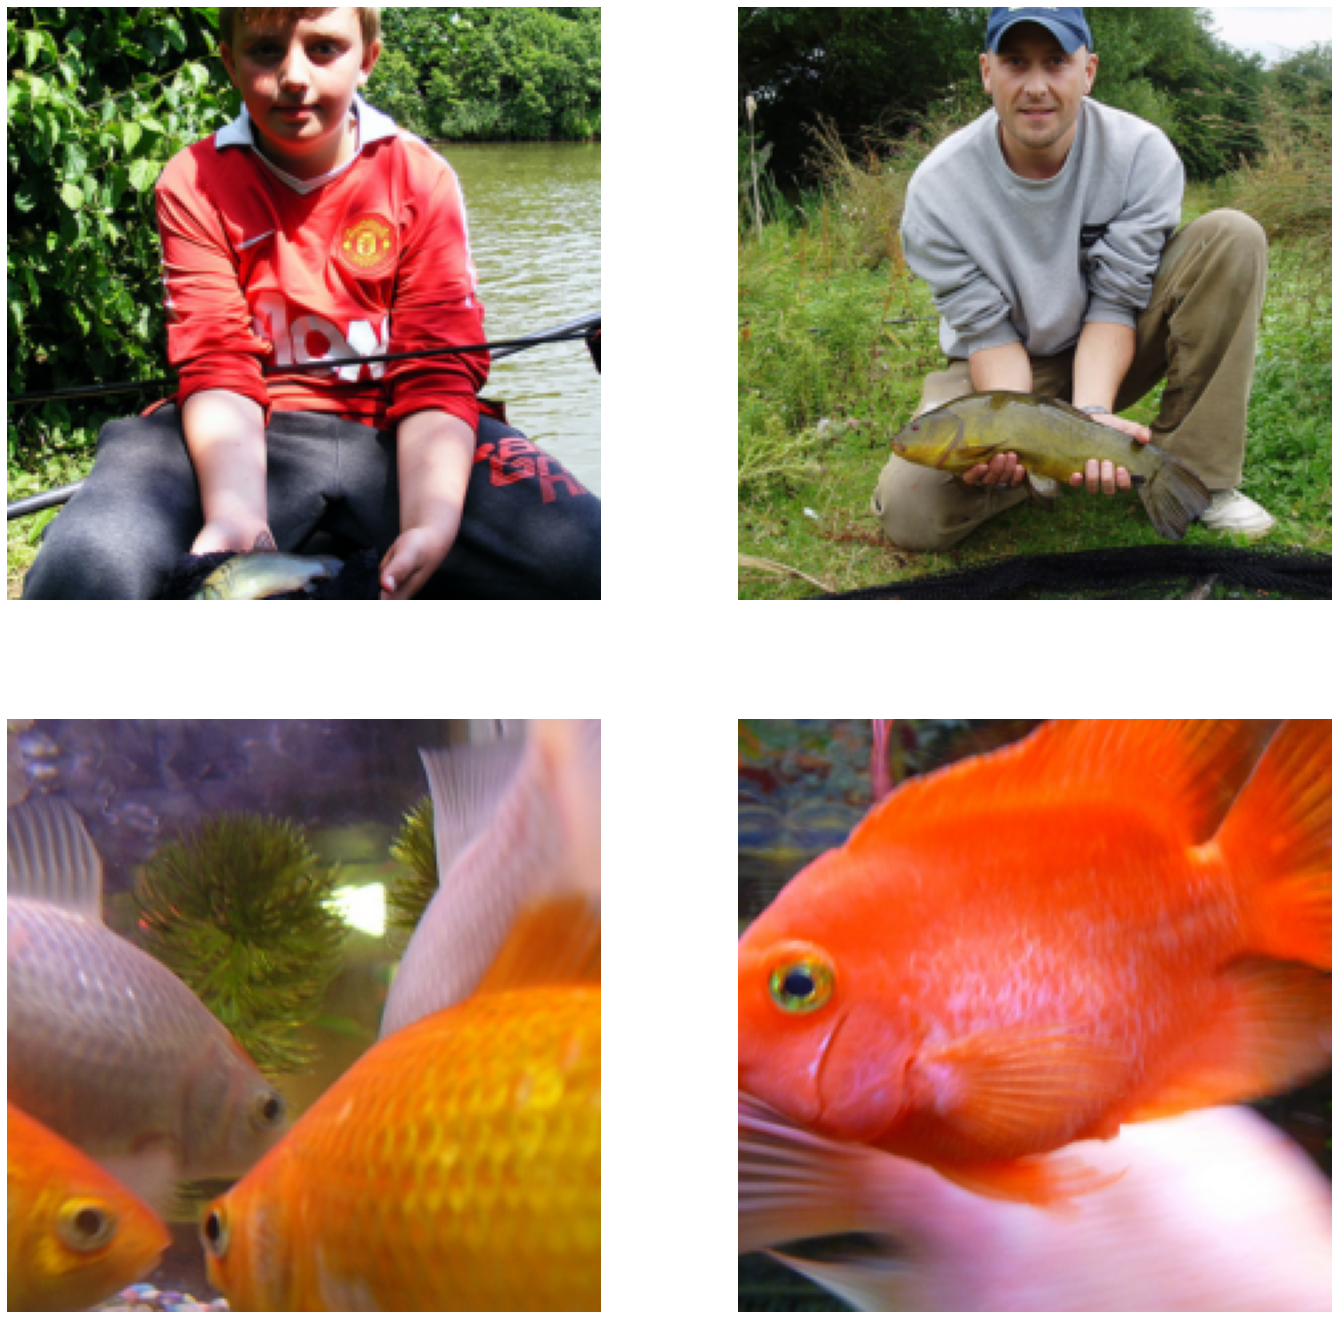

In [30]:
user.plot(true_user_data)

### Reconstruct user data:

In [9]:
tmp_share_data = copy.deepcopy(shared_data)
tmp_share_data['metadata']['num_data_points'] = how_many_rec
tmp_share_data['metadata']['labels'] = shared_data['metadata']['labels'][which_to_recover:(which_to_recover + how_many_rec)]
tmp_true_user_data = {}
tmp_true_user_data['data'] = true_user_data['data'][which_to_recover:(which_to_recover + how_many_rec)]
tmp_true_user_data['labels'] = true_user_data['labels'][which_to_recover:(which_to_recover + how_many_rec)]

In [10]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [tmp_share_data], 
                                                      server.secrets, dryrun=cfg.dryrun)

No valid reconstruction could be found.


In [11]:
#How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, tmp_true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

D:\anaconda\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


METRICS: | MSE: 0.0165 | PSNR: 17.83 | FMSE: 9.1162e+05 | LPIPS: 0.95|
 R-PSNR: 17.83 | IIP-pixel: 100.00% | SSIM: 0.0006 | Label Acc: 100.00%


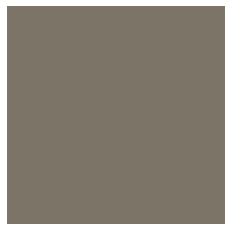

In [12]:
user.plot(reconstructed_user_data)

In [13]:
server.model(true_user_data['data'])[:, :5]

tensor([[ 980.5010,  443.6837,  881.9677,  867.2728,  760.4243],
        [1868.3552,  292.5820,  252.3150,  555.9290,  536.0544],
        [1370.1246, 1124.4080,  303.2461,  452.2603,  990.8930],
        [1551.5476, 1441.3458,  396.0980,  556.8439,  758.6034],
        [1395.3201,  356.7657, 2184.0674, 1819.3125, 1649.1957],
        [1501.0710,  538.8419, 2896.0674, 2402.2036, 2054.7844],
        [1411.6685,  317.1572, 2945.7842, 3030.8013, 2013.1685],
        [1465.0242,  320.9922, 1287.6613, 1395.8276, 1219.7675]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [14]:
server.model(true_user_data['data'])[:, true_user_data['labels']]

tensor([[ 980.5010,  980.5010,  443.6837,  443.6837,  881.9677,  881.9677,
          867.2728,  867.2728],
        [1868.3552, 1868.3552,  292.5820,  292.5820,  252.3150,  252.3150,
          555.9290,  555.9290],
        [1370.1246, 1370.1246, 1124.4080, 1124.4080,  303.2461,  303.2461,
          452.2603,  452.2603],
        [1551.5476, 1551.5476, 1441.3458, 1441.3458,  396.0980,  396.0980,
          556.8439,  556.8439],
        [1395.3201, 1395.3201,  356.7657,  356.7657, 2184.0674, 2184.0674,
         1819.3125, 1819.3125],
        [1501.0710, 1501.0710,  538.8419,  538.8419, 2896.0674, 2896.0674,
         2402.2036, 2402.2036],
        [1411.6685, 1411.6685,  317.1572,  317.1572, 2945.7842, 2945.7842,
         3030.8013, 3030.8013],
        [1465.0242, 1465.0242,  320.9922,  320.9922, 1287.6613, 1287.6613,
         1395.8276, 1395.8276]], device='cuda:0', grad_fn=<IndexBackward0>)

In [15]:
server.model(target_img.unsqueeze(0))[:, :5]

tensor([[992.6306, 455.7219, 777.7259, 752.4313, 711.6270]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [16]:
singl_gradients, single_losses = server.cal_single_gradients(attacker, true_user_data)
server.print_gradients_norm(singl_gradients, single_losses)

grad norm         loss
64424.0859375 388.921875
0.0 0.0
39581.81640625 646.52978515625
38850.55859375 110.2017822265625
0.0 0.0
0.0 0.0
0.0 0.0
53335.453125 69.1964111328125
